In [7]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from annotations import AnnoImage, AnnoPair, load_annotations, save_annotations, plot_pair, plot_annotations, create_annotation_pairs, points_from_pairs
from utils import read_images


display_resolutions = (1200,1200)
display_offset = (0,0)

#input paths
w_filepath = r"../data/rgb"
t_filepath = r"../data/thermal"
output_folder = r"../data/pairs"
anno_file = r"../data/pairs.xml"

# load annotations
pairs = load_annotations(anno_file, w_filepath, t_filepath)

# extract points
T_points, W_points, TW_names = points_from_pairs(pairs)
print( W_points.shape, T_points.shape)
print(TW_names)

# compute the homography matrix
#H = cv2.findHomography(np.array([annotations[0]['keypoints']['building_0'], annotations[0]['keypoints']['building_1'], annotations[0]['keypoints']['building_2'], annotations[0]['keypoints']['building_3']]), np.array([annotations[1]['keypoints']['building_0'], annotations[1]['keypoints']['building_1'], annotations[1]['keypoints']['building_2'], annotations[1]['keypoints']['building_3']]))[0]
M, mask = cv2.findHomography(W_points, T_points, cv2.RANSAC, 15)
matchesMask = mask.ravel().tolist()
print(M, matchesMask)

# dissect homography matrix into rotation, translation and scale
def decompose_homography_matrix(H):
    # get the rotation matrix
    R = H[0:2, 0:2]
    # get the translation
    t = H[0:2, 2]
    # get the scale
    s = np.sqrt(np.sum(R**2, axis=0))
    # normalize the rotation matrix
    R = R / s
    # get the angle
    theta = np.arctan2(R[1, 0], R[0, 0])
    return R, t, s, theta

R, t, s, theta = decompose_homography_matrix(M)
print(R, t, s, theta)

(7, 1, 2) (7, 1, 2)
['frame_000022.jpg_0', 'frame_000022.jpg_1', 'frame_000022.jpg_2', 'frame_000024.jpg_0', 'frame_000024.jpg_1', 'frame_000025.jpg_0', 'frame_000025.jpg_1']
[[ 7.81885258e-01  1.59482235e-01 -9.00204060e+02]
 [ 4.14497879e-02  7.73558069e-01 -5.44475354e+02]
 [ 9.59071929e-05  1.32437731e-04  1.00000000e+00]] [0, 1, 1, 1, 1, 1, 1]
[[0.99859779 0.20192047]
 [0.05293829 0.97940192]] [-900.20405973 -544.47535408] [0.78298317 0.78982699] 0.05296304478142653


In [2]:
# compute reprojection error (mean squared error)

# warp the points from the thermal image to the wide image
W_points_warped = cv2.perspectiveTransform(W_points, M)

# compute the mean squared error
error = np.sum((W_points_warped - T_points)**2) / T_points.shape[0]
print('mean squared error: {}'.format(error))

mean squared error: 72.25614599095306


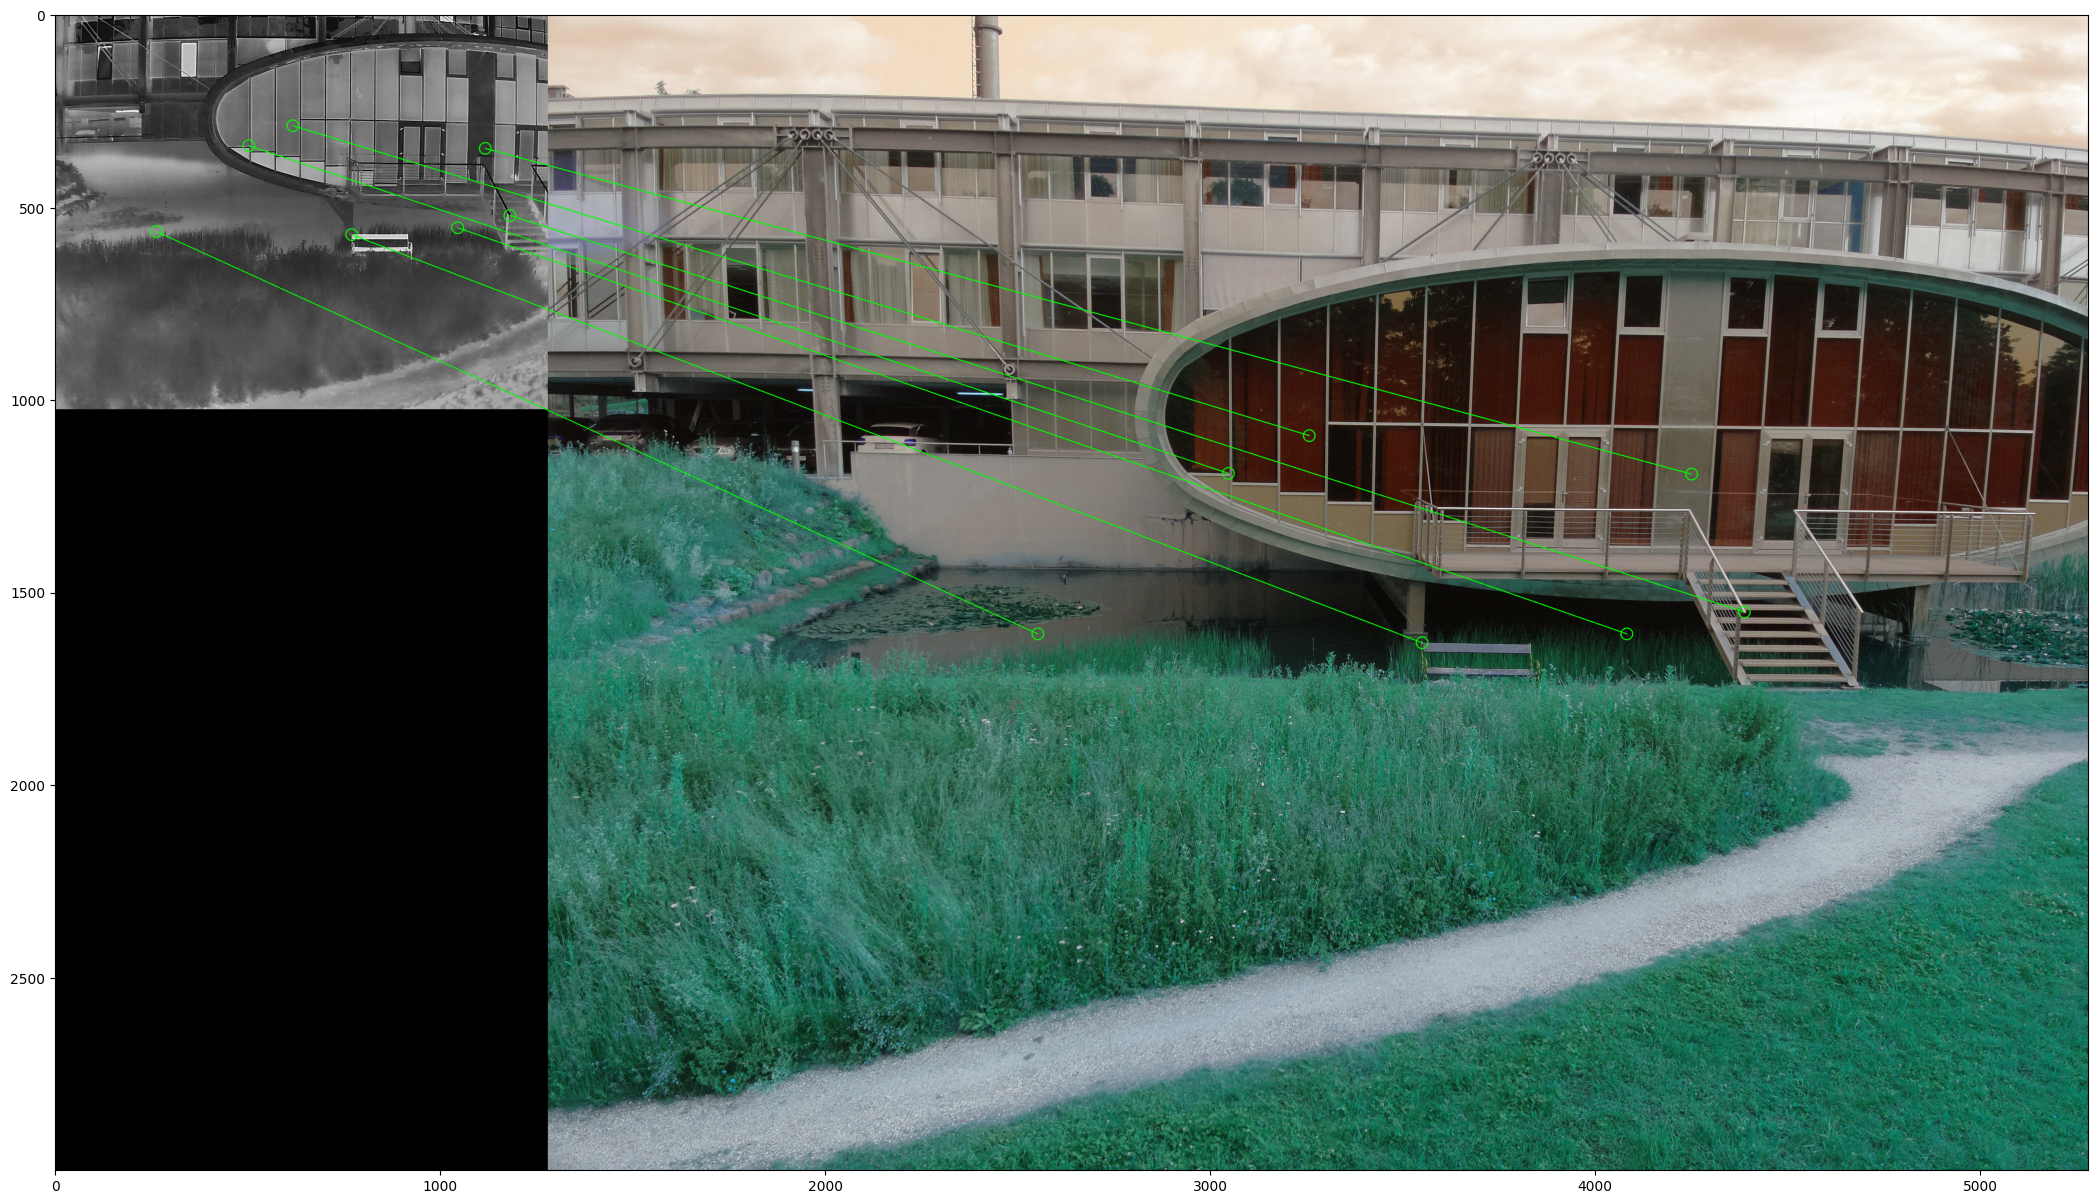

In [ ]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   matchesThickness = 2,
                   flags = 2)

# construct a matches array of shape (n,2) where n is the number of matches
matches = np.zeros((len(matchesMask),2), dtype=np.int32)
for i in range(len(matchesMask)):
    matches[i] = [i,i]

# get the first pair for displaying
T,W = pairs[0]["T"], pairs[0]["W"]

img3 = draw_matches(T.original_image, T_points.reshape(-1,2), W.original_image, W_points.reshape(-1,2), matches, color=(0,255,0))

plt.figure(figsize=(30,15))
plt.imshow(img3, 'gray')
plt.show()

In [8]:
T_points.shape

(7, 1, 2)

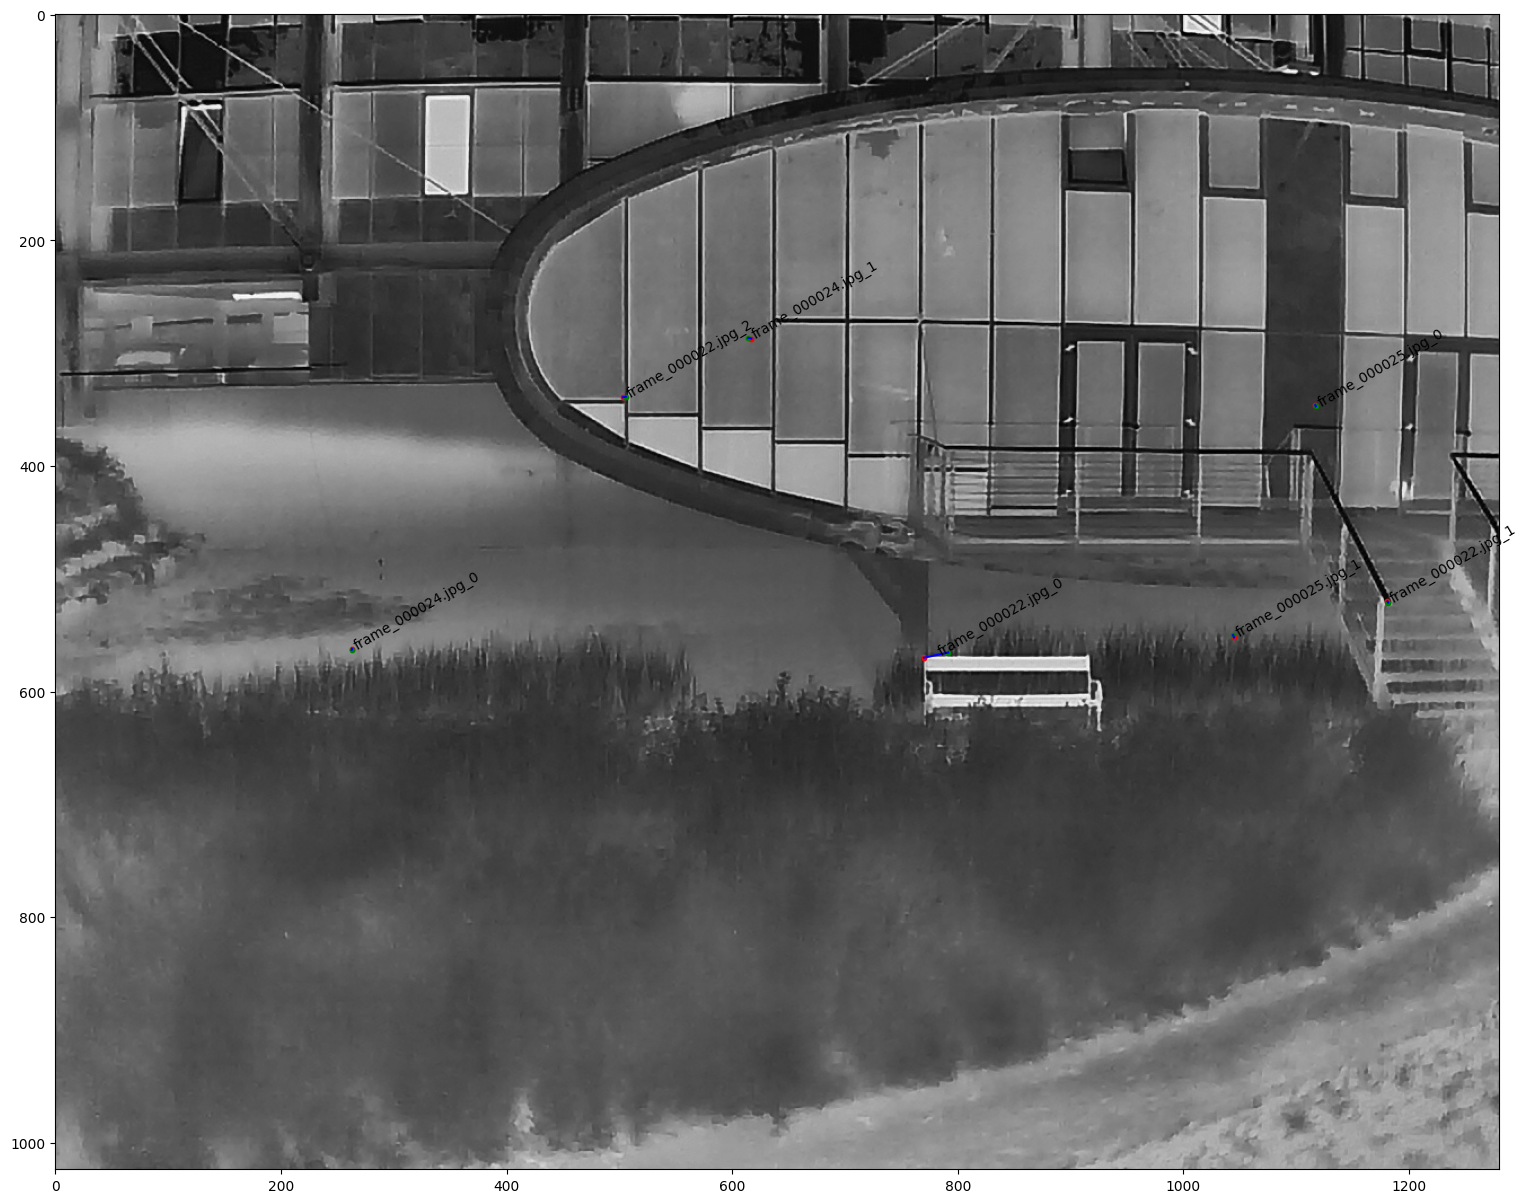

In [9]:
# warp the points from the wide image to the thermal image
W_points_warped = cv2.perspectiveTransform(W_points, M)

# draw the original and warped points on the thermal image

plt.figure(figsize=(30,15))
plt.imshow(T.original_image)
plt.scatter(T_points[:,0,0], T_points[:,0,1], c='r', s=10)
plt.scatter(W_points_warped[:,0,0], W_points_warped[:,0,1], c='g', s=10)
plt.plot( [T_points[:,0,0], W_points_warped[:,0,0]], [T_points[:,0,1], W_points_warped[:,0,1]], c='b' )
# plot names in the middle of the line
for i in range(len(T_points)):
     plt.text((T_points[i,0,0] + W_points_warped[i,0,0])/2, (T_points[i,0,1] + W_points_warped[i,0,1])/2, TW_names[i][:], color='black', rotation=30)
plt.show()

Hacked in Camera Calibration for the M30T

In [26]:
# Hacked in Camera Calibration for the M30T

ss = {
    'Thermal': {'ret': 0.16100025970837398,
                'mtx': [[1517, 0.0, 1280 / 2 - .5],
                        [0.0, 1517, 1024 / 2 - .5],
                        [0.0, 0.0, 1.0]],
                'dist': [[-0.3, 0.15, 0.00, -.01, 0.0]]},
    # Agis Calibration (indoor/close-distance with checkerboard)
    'Wide': {'ret': 0.45476092217465214,
             'mtx': [[1.43609409555281695e+03, 0.0, 1920 / 2 - .5],
                     [0.0, 1.43609409555281695e+03, 1080 / 2 - .5],
                     [0.0, 0.0, 1.0]],
             'dist': [
                 [2.75581711404002117e-01, -9.38484309546720574e-01, 6.43997697294128031e-04, 5.53460895923792596e-04,
                  9.46595358456289060e-01]]},
}

# COLMAP outdoor flight (~40m away)
#1 SIMPLE_RADIAL 1920 1080 1157.6312011037576 960 540 -0.094934316109354933
ss['Wide'] = {
    'ret': 0.8,
    'mtx': [[1223.28, 0.0, 960],
            [0.0, 1223.286, 540],
            [0.0, 0.0, 1.0]],
    'dist': [[0.0, 0.0, 0.0, 0.0, 0.0]]
}

# COLMAP outdoor flight (~40m away) - OpenCV camera model WITHOUT principal point modification
# Camera list with one line of data per camera:
#1 OPENCV 1920 1080 1399.9382736962802 1497.8404811669732 960 540 0.1281916216582546 -0.22464118766315344 -0.001310140741772796 0.0042675975192878893
ss['Wide'] = {
    'ret': None,
    'mtx': [[1399.9382736962802, 0.0, 960],
            [0.0, 1497.8404811669732, 540],
            [0.0, 0.0, 1.0]],
    'dist': [[0.1281916216582546, -0.22464118766315344, -0.001310140741772796, 0.0042675975192878893, 0.0]]
}

# # COLMAP outdoor flight (~40m away) - OpenCV camera model with principal point modification
# # OpenCV camera model 
# #1 OPENCV 1920 1080 1401.1060852138025 1513.4450677058701 980.97910742141732 522.17830819653329 0.13296375297867741 -0.22427639791325912 -0.0012797761146739366 -0.0034950321537962005
# ss['Wide'] = {
#     'ret': None, 
#     'mtx': [[1401.1060852138025, 0.0, 980.97910742141732],
#       [0.0, 1513.4450677058701, 522.17830819653329],
#       [0.0, 0.0, 1.0]],
#     'dist': [[0.13296375297867741, -0.22427639791325912, -0.0012797761146739366, -0.0034950321537962005, 0.0]]
# }

# COLMAP flight on FH3 facade with 4 distances (30m, 40m, 50m, 60m)
# AFTER BUNDLE ADJUST (with all params)
# Camera list with one line of data per camera:
#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
# Number of cameras: 1
# 1 OPENCV 3840 2160 4239.86 4163.17 991.449 736.395 -0.0028057 -0.00959419 0.00493505 -0.00438148
# --> The principal point is weird!!! 

# RECONSTRUCTION on DGX with FH3 facade with 4 distances (30m, 40m, 50m, 60m)
#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
# Number of cameras: 1
#1 OPENCV 3840 2160 2888.9567510496149 2925.3573060790463 1931.3613579581895 1025.706364205322 0.12190146750932081 -0.22602465494449309 0.0010812392211104588 -0.0014236837872635538


ss['Wide'] = {
    'ret': None,
    'mtx': [    [2888.9567510496149, 0.0, 1931.3613579581895],
                [0.0, 2925.3573060790463, 1025.706364205322],
                [0.0, 0.0, 1.0]],
        'dist': [[0.12190146750932081, -0.22602465494449309, 0.0010812392211104588, -0.0014236837872635538, 0.0]]
}

# RECONSTRUCTION on DGX with Haag scene (fly around the building)
#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
#1 OPENCV 3840 2160 2888.1783249157652 2819.3160759551897 1929.0179499431672 1070.7804294784548 0.13853585738444427 -0.25508562557544706 0.00020336601637138113 -0.00090574723833968852
ss['Wide'] = {
    'ret': None,
    'mtx': [    [2888.1783249157652, 0.0, 1929.0179499431672],
                [0.0, 2819.3160759551897, 1070.7804294784548],
                [0.0, 0.0, 1.0]],
        'dist': [[0.13853585738444427, -0.25508562557544706, 0.00020336601637138113, -0.00090574723833968852, 0.0]]
}

Hacked in Camera Calibration for the M3T of Spektakulair 

In [64]:
# RECONSTRUCTION on DGX with Haag scene (fly around the building)
# Location: \BAMBI - DATA\FH\TMP\CALIB\Haag\colmap_dgxa100\txt_sparse_ba

# Camera list with one line of data per camera:
#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
# 2 OPENCV 3840 2160 2985.574345605201 2916.5305410170249 1933.8876420817091 1082.4606165061921 0.13944354692433603 -0.26558585052038536 -0.00084940788168530164 -0.0012549880485660388
ss["Wide"] = {
    'ret': None,
    'mtx': np.array([[2985.574345605201, 0.0, 1933.8876420817091],
                        [0.0, 2916.5305410170249, 1082.4606165061921],
                        [0.0, 0.0, 1.0]]),
    'dist': np.array([0.13944354692433603, -0.26558585052038536, -0.00084940788168530164, -0.0012549880485660388, 0.0]),
}

# default values for thermal camera (based on props from website: https://enterprise.dji.com/de/mavic-3-enterprise/specs)
# M30T Thermal: {'w': 640, 'h': 512, 'fov_x': 70.22190854795122, 'fov_y': 58.71358740430744, 'focal_length_x_px': 455.1289543743393, 'focal_length_y_px': 455.1289543743395}
ss['Thermal'] = {
    'ret': 0.16100025970837398,
    'mtx': [[455, 0.0, 640 / 2 - .5],
                        [0.0, 455, 512 / 2 - .5],
                        [0.0, 0.0, 1.0]],
    'dist': [[0,0,0,0,0]]
}


Hacked in Camera Calibration for the M30T_02 (with half resolution on the Wide)

In [137]:
# RECONSTRUCTION on DGX with Haag scene (fly around the building)
#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
#1 OPENCV 3840 2160 2888.1783249157652 2819.3160759551897 1929.0179499431672 1070.7804294784548 0.13853585738444427 -0.25508562557544706 0.00020336601637138113 -0.00090574723833968852
ss['Wide'] = {
    'ret': None,
    'mtx': [    [2888.1783249157652/2, 0.0, 1929.0179499431672/2],
                [0.0, 2819.3160759551897/2, 1070.7804294784548/2],
                [0.0, 0.0, 1.0]],
        'dist': [[0.13853585738444427, -0.25508562557544706, 0.00020336601637138113, -0.00090574723833968852, 0.0]]
}

Hacked in Camera Calibration for the M30T_VC (sadly with half resolution on the Wide)
The camera calibration is reused from the FH M30T_02

In [35]:
# RECONSTRUCTION of FH's M30T_02 on DGX with Haag scene (fly around the building)
#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
#1 OPENCV 3840 2160 2888.1783249157652 2819.3160759551897 1929.0179499431672 1070.7804294784548 0.13853585738444427 -0.25508562557544706 0.00020336601637138113 -0.00090574723833968852
ss['Wide'] = {
    'ret': None,
    'mtx': [    [2888.1783249157652/2, 0.0, 1929.0179499431672/2],
                [0.0, 2819.3160759551897/2, 1070.7804294784548/2],
                [0.0, 0.0, 1.0]],
        'dist': [[0.13853585738444427, -0.25508562557544706, 0.00020336601637138113, -0.00090574723833968852, 0.0]]
}

In [61]:
saver = CalibrationSaver()
#saver.get(get_resource("calibration.db"), "DJI_M300", "Wide", normalize_calibration=True)

dst_size = (1024, 1024)
f = min(*dst_size)
new_camera_matrix = np.array([[f, 0.0, dst_size[0] / 2 - .5],
                              [0.0, f, dst_size[1] / 2 - .5],
                              [0.0, 0.0, 1.0]])

#drone_name = "DJI_M2EA"  # or "DJI_M30", "DJI_M2EA"
cameras = ["Wide", "Thermal"]

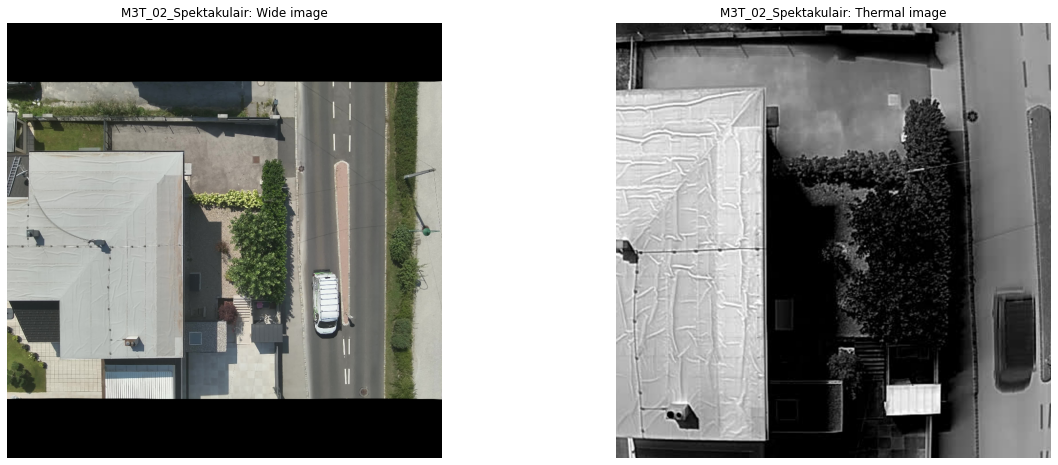

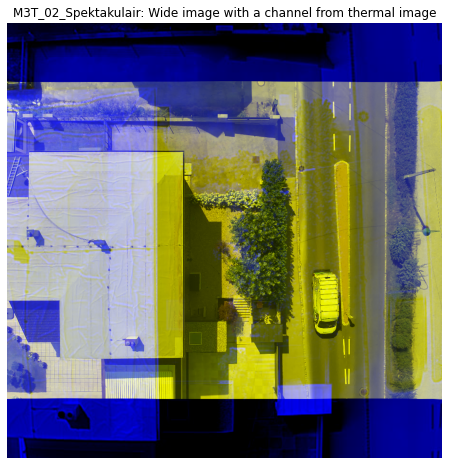

In [65]:
image_ext = "jpg"

plt.figure(figsize=(20, 8))
for i, camera in enumerate(cameras):
    #calib = saver.get(get_resource("calibration.db"), drone_name, camera, normalize_calibration=True)
    calib = ss.get(camera)
    assert calib is not None
    # camera matrix
    camera_matrix = np.array(calib['mtx'])
    #print(camera_matrix)
    # k1, k2, p1, p2, k3
    dist_coefs = np.array(calib['dist'])
    #print(dist_coefs.shape)
    #dist_coefs = np.zeros_like(dist_coefs)
    #dist_coefs[0, 2:4] = [0, 0]
    #dist_coefs[0, 0:2] = [0, 0.5]

    # the folder name is the drone_name without the DJI_ prefix
    # check if the image exists
    assert os.path.exists(get_resource(f'calibration_/{drone_name}/{camera}.{image_ext}')), f"Image {camera}.{image_ext} does not exist for {drone_name} in the calibration folder"
    img = cv2.imread(get_resource(f'calibration_/{drone_name}/{camera}.{image_ext}'))
    #img = cv2.resize(img, (640, 512)) # half resolution
    #print(img.shape)

    # remove the the lens distortions
    mapx, mapy = cv2.initUndistortRectifyMap(camera_matrix, dist_coefs, None,
                                                new_camera_matrix, dst_size, cv2.CV_32FC1)
    dst = cv2.remap(img, mapx, mapy, cv2.INTER_CUBIC)
    #print(dst_T.shape) 

    plt.subplot(1, len(cameras), i + 1)
    imshow(dst, cmap='gray')
    plt.title(f'{drone_name}: {camera} image')

    if camera == "Wide":
        wide_img = dst.copy()
    else:
        thermal_img = dst.copy()
        cmp_img = wide_img.copy()
        cmp_img[:, :, 0] = thermal_img[:, :, 0]  # copy a channel from the thermal image

plt.show()  # show the images

plt.figure(figsize=(12, 8))
imshow(cmp_img, cmap='gray')
plt.title(f'{drone_name}: Wide image with a channel from thermal image')
plt.show()

In [66]:
def warp_points(pts, camera_matrix, dist_coefs=None, new_camera_matrix=None):
    """Warp points from the original image to the undistorted image.
    """
    if dist_coefs is None:
        dist_coefs = np.zeros((1, 5))
    if new_camera_matrix is None:
        new_camera_matrix = camera_matrix

    pts = np.array(pts).astype(np.float32)
    pts = pts.reshape(-1, 1, 2)
    pts = cv2.undistortPoints(pts, camera_matrix, dist_coefs, P=new_camera_matrix)
    
    return pts.reshape(-1, 1, 2)

# test the function
pts = [[100, 100], [200, 200], [300, 300]]
pts = warp_points(pts, camera_matrix, dist_coefs, new_camera_matrix)
print(pts)

[[[ 17.504396 161.53957 ]]

 [[242.55934  386.5945  ]]

 [[467.6143   611.6495  ]]]


In [67]:
def mse_warped_points(thermal_fx:float, thermal_fy:float, thermal_cx:float, thermal_cy:float, 
                      thermal_k1=0, thermal_k2=0, thermal_p1=0, thermal_p2=0, thermal_k3=0,
                      thermal_ox=0, thermal_oy=0, thermal_sx=1, thermal_sy=1):
    #plt.figure(figsize=(20, 8))
    new_points = {}
    for i, camera in enumerate(cameras):
        #calib = saver.get(get_resource("calibration.db"), drone_name, camera, normalize_calibration=True)
        calib = ss.get(camera)
        assert calib is not None
        # camera matrix
        if camera == "Thermal":
            camera_matrix = np.array([[thermal_fx, 0.0, thermal_cx],
                                      [0.0, thermal_fy, thermal_cy],
                                      [0.0, 0.0, 1.0]])
            dist_coeffs = np.array([[thermal_k1, thermal_k2, thermal_p1, thermal_p2, thermal_k3]])

            img_points = T_points 

        else: # Wide
            camera_matrix = np.array(calib['mtx'])
            # k1, k2, p1, p2, k3
            dist_coeffs = np.array(calib['dist'])

            img_points = W_points

       
        new_points[camera] = warp_points(img_points, camera_matrix, dist_coeffs, new_camera_matrix)
        if camera == "Thermal":
            new_points[camera] = new_points[camera] * np.array([thermal_sx, thermal_sy]) + np.array([thermal_ox, thermal_oy])


    #print(next(iter(new_points.values())).shape)
    np_warped_points = np.concatenate(list(new_points.values()), axis=1)
    #print(np_warped_points.shape)

    # compute the mean squared error
    error = np.sum(np.diff(np_warped_points, axis=1)**2, axis=2).mean()
    #print('mean squared error: {}'.format(error))

    return error

mse_warped_points(4239.86, 4239.86, 991.449, 736.395, -0.0028057, -0.00959419, 0.00493505, -0.00438148, 0.0)

106388.25057382413

In [68]:
# use scipy.optimize.minimize to find the best parameters for the thermal camera

from scipy.optimize import minimize

# thermal_fx, thermal_fy, thermal_cx, thermal_cy, thermal_k1, thermal_k2, thermal_p1, thermal_p2, thermal_k3
# use the mse_warped_points function to find the best parameters for the thermal camera
#x0 = [ 2.14576677e+03, 2.14576677e+03, 1.46951821e+02,  3.36187014e+02, -2.60889907e-03,
#   -1.37946591e-02,  5.95762355e-03, -6.69787913e-03,  4.77340076e-04]
x0 = [ 500, 500, 640/2, 512/2, 0, 0, 0, 0] # initial guess for 640x512 
#x0 = [ 1000, 1000, 640, 512, 0, 0, 0, 0,] # initial guess for 1280x1024
#xx = list(x0.ravel()), xx.append(0)
#x0 = xx 
N_iters = 20
for i in range(N_iters):
    res = minimize(lambda x: mse_warped_points(*x), x0, method='Nelder-Mead', options={'disp': True, 'maxiter': 100000}, tol=.0001)
    x0 = res.x

print(res.x)
print(mse_warped_points(*res.x))

Optimization terminated successfully.
         Current function value: 69.862726
         Iterations: 219
         Function evaluations: 420
Optimization terminated successfully.
         Current function value: 9.459424
         Iterations: 626
         Function evaluations: 976
Optimization terminated successfully.
         Current function value: 6.695998
         Iterations: 553
         Function evaluations: 859
Optimization terminated successfully.
         Current function value: 6.695972
         Iterations: 132
         Function evaluations: 281
Optimization terminated successfully.
         Current function value: 6.695967
         Iterations: 122
         Function evaluations: 274
Optimization terminated successfully.
         Current function value: 6.695967
         Iterations: 126
         Function evaluations: 271
Optimization terminated successfully.
         Current function value: 6.695967
         Iterations: 126
         Function evaluations: 271
Optimization termin

[[822.31400994   0.         324.32423084]
 [  0.         803.32564299 255.80441134]
 [  0.           0.           1.        ]]
[[-0.43915574  0.25344167 -0.00090464 -0.0051258   0.        ]]


<Figure size 1440x576 with 0 Axes>

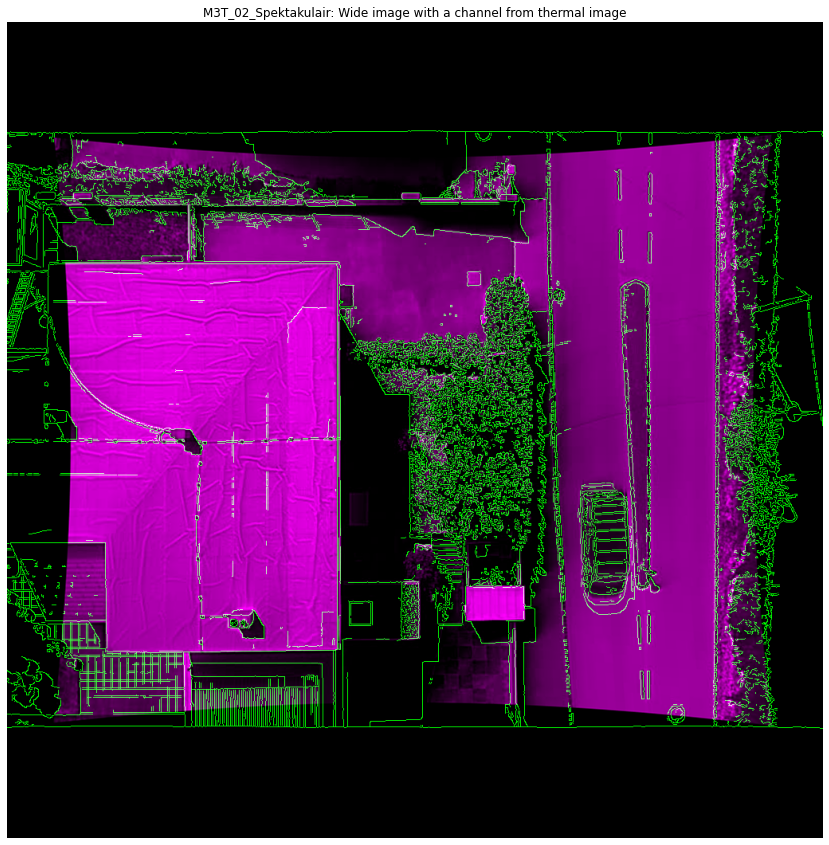

In [69]:
# make an interactive plot
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

image_ext = "jpg"

def update_matrix(thermal_fx, thermal_fy, thermal_cx, thermal_cy, thermal_k1, thermal_k2, thermal_p1, thermal_p2, thermal_k3,
                  drone_name="DJI_M30", show_individual_images=False):
    plt.figure(figsize=(20, 8))
    for i, camera in enumerate(cameras):
        #calib = saver.get(get_resource("calibration.db"), drone_name, camera, normalize_calibration=True)
        calib = ss.get(camera)
        assert calib is not None
        # camera matrix
        if camera == "Thermal":
            camera_matrix = np.array([[thermal_fx, 0.0, thermal_cx],
                                      [0.0, thermal_fy, thermal_cy],
                                      [0.0, 0.0, 1.0]])
            dist_coefs = np.array([[thermal_k1, thermal_k2, thermal_p1, thermal_p2, thermal_k3]])
            print(camera_matrix)
            print(dist_coefs)
        else:
            camera_matrix = np.array(calib['mtx'])
            # k1, k2, p1, p2, k3
            dist_coefs = np.array(calib['dist'])

        # the folder name is the drone_name without the DJI_ prefix
        #folder_name = drone_name[4:]
        img = cv2.imread(get_resource(f'calibration_/{drone_name}/{camera}.{image_ext}'))
        #img = cv2.resize(img, (640, 512)) # half resolution
        #print(img.shape)
        #if camera == "Wide":
        #    img = W.original_image
        #else:
        #    img = T.original_image

        # remove the the lens distortions
        mapx, mapy = cv2.initUndistortRectifyMap(camera_matrix, dist_coefs, None,
                                                 new_camera_matrix, dst_size, cv2.CV_32FC1)
        dst = cv2.remap(img, mapx, mapy, cv2.INTER_CUBIC)
        #print(dst_T.shape) 

        if show_individual_images:
            plt.subplot(1, len(cameras), i + 1)
            imshow(dst, cmap='gray')
            plt.title(f'{drone_name}: {camera} image')
            plt.show()  # show the images


        if camera == "Wide":
            # apply an edge detector on the wide image
            dst = cv2.Canny(dst.copy(), 100, 200)
            wide_img_edge = cv2.cvtColor(dst, cv2.COLOR_GRAY2RGB)
        else:
            thermal_img = dst.copy()
            cmp_img = thermal_img.copy()
            cmp_img[:, :, 1] = wide_img_edge[:, :, 1]  # copy a channel from the thermal image


    plt.figure(figsize=(15, 15))
    imshow(cmp_img, cmap='gray')
    plt.title(f'{drone_name}: Wide image with a channel from thermal image')
    plt.show()


# default values from ss.get("Thermal")
t_fx = ss.get("Thermal")['mtx'][0][0]
t_fy = ss.get("Thermal")['mtx'][1][1]
t_cx = ss.get("Thermal")['mtx'][0][2]
t_cy = ss.get("Thermal")['mtx'][1][2]
t_k1 = ss.get("Thermal")['dist'][0][0]
t_k2 = ss.get("Thermal")['dist'][0][1]
t_p1 = ss.get("Thermal")['dist'][0][2]
t_p2 = ss.get("Thermal")['dist'][0][3]
t_k3 = ss.get("Thermal")['dist'][0][4]

# check if res.x is defined
if 'res' in locals():
    t_fx = res.x[0]
    t_fy = res.x[1]
    t_cx = res.x[2]
    t_cy = res.x[3]
    t_k1 = res.x[4]
    t_k2 = res.x[5]
    t_p1 = res.x[6]
    t_p2 = res.x[7]
    t_k3 = res.x[8] if len(res.x) > 8 else 0

update_matrix(t_fx, t_fy, t_cx, t_cy, t_k1, t_k2, t_p1, t_p2, t_k3, drone_name=drone_name, show_individual_images=False)

In [70]:
# print the fx fy cx cy and the distortion coefficients in markdown table format

print(f'| {res.x[0]} | {res.x[1]} | {res.x[2]} | {res.x[3]} | {res.x[4]}, {res.x[5]}, {res.x[6]}, {res.x[7]}, {res.x[8] if len(res.x)>=9 else 0} | ')

| 822.314009942424 | 803.3256429897012 | 324.3242308380196 | 255.80441133813778 | -0.43915573819396414, 0.253441668942241, -0.0009046407844919575, -0.00512580043670358, 0 | 
